## Code to have 2D Maxwell (with B in the direction z) using SummationByParts operators.

This is to be ported to the PIC code.

In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays

In [2]:
include("../../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")

RK4_Step!! (generic function with 1 method)

In [19]:
J = (100,100)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [20]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])

Periodic first-derivative operator of order 6 on a grid in [0.0, 1.0] using 100 nodes, 
stencils with 3 nodes to the left, 3 nodes to the right, and coefficients of Fornberg (1998) 
  Calculation of Weights in Finite Difference Formulas. 
  SIAM Rev. 40.3, pp. 685-691.

### Initial Data

In [47]:
#k = 2π*[3,3]
#fe(x,y) = sin(k[1]*x)*sin(k[2]*y)
function fp(x,y) 
    x0 = [0.5,0.5]
    r20 = 0.1
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r2 - r20)^2
    else
        return 0.0
    end
end
Ea = [((2-l)*(yv[j] - 0.5) - (l-1)*(xv[i] - 0.5))*fp(xv[i],yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B = [fp(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];


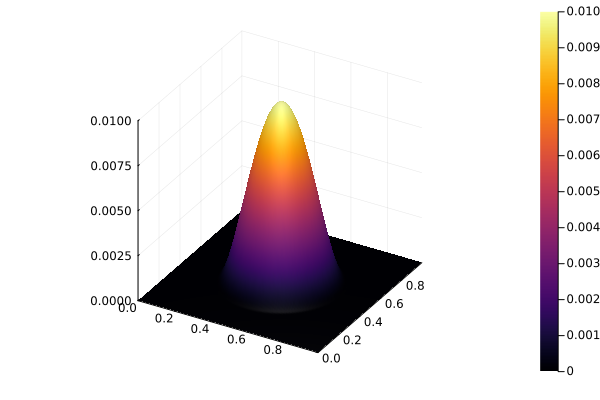

In [26]:
surface(yv,xv,B)

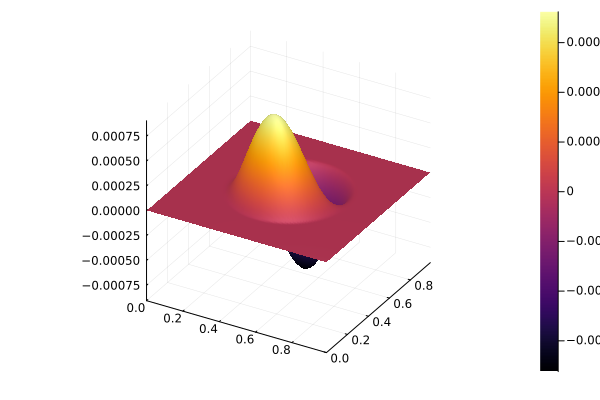

In [29]:
surface(yv,xv,Ea[2,:,:])

We upload the initial data onto the evolution vector.

In [67]:
u = Vector{Float64}(undef,3*J[1]*J[2])
du = Vector{Float64}(undef,3*J[1]*J[2])

F = reshape(u,3,J[1],J[2])

F[1:2,:,:] = Ea
F[3,:,:] = B;

Check that it is OK for this toy data.

In [52]:
@show F[1,30,40]
@show F[2,30,20]
@show F[3,30,20]

F[1, 30, 40] = -0.00021102839999999996
F[2, 30, 20] = 0.0
F[3, 30, 20] = 0.0


0.0

Define the vectors to put the space derivatives.

In [85]:
function F!(u, t, par)
    du = par
    u_a = reshape(u,(3,J...))
    Du_a = reshape(du,(3,J...))
    for i in 1:J[1]
        mul!(view(Du_a,1,i,:),Dy, view(u_a,3,i,:),one(eltype(u_a)))
        mul!(view(Du_a,3,i,:),Dy, view(u_a,1,i,:),one(eltype(u_a)))
    end
    for j in 1:J[2]
        mul!(view(Du_a,2,:,j),Dx, view(u_a,3,:,j),-one(eltype(u_a)))
        mul!(view(Du_a,3,:,j),Dx, view(u_a,2,:,j),-one(eltype(u_a)),one(eltype(u_a)))
    end
    return du[:]
end

F! (generic function with 1 method)

In [54]:

function get_Energy(u,J,Box)
    U_a = reshape(u,(3,J...))
    return norm(U_a)^2
end

get_Energy (generic function with 1 method)

In [94]:
(t_i, t_f) = (0.0, 1.0)
M = 100
@show dt = (t_f - t_i)/M
par = du
t = t_i
get_Energy(u,J,Box)


dt = (t_f - t_i) / M = 0.01


0.06387903329360264

In [95]:
F[1:2,:,:] = Ea
F[3,:,:] = B;

for i in 1:M
    RK4_Step!(F!, u, 0.0, dt, par)
    t = t + dt
    println("t = $t")
    println("Energy = $(get_Energy(u,J,Box))")
end

t = 0.01
Energy = 0.06387904024469902
t = 0.02
Energy = 0.06387903052395366
t = 0.03
Energy = 0.06387902125776813
t = 0.04
Energy = 0.06387901234045981


t = 0.05
Energy = 0.0638790037034176
t = 0.060000000000000005
Energy = 0.06387899529910131
t = 0.07
Energy = 0.06387898709278894
t = 0.08
Energy = 0.06387897905805395
t = 0.09
Energy = 0.06387897117413226
t = 0.09999999999999999
Energy = 0.06387896342429956
t = 0.10999999999999999
Energy = 0.0638789557948188
t = 0.11999999999999998
Energy = 0.06387894827422685
t = 0.12999999999999998
Energy = 0.06387894085283227
t = 0.13999999999999999
Energy = 0.06387893352235098
t = 0.15
Energy = 0.06387892627563466
t = 0.16
Energy = 0.06387891910646407


t = 0.17
Energy = 0.06387891200938864
t = 0.18000000000000002
Energy = 0.06387890497960026
t = 0.19000000000000003
Energy = 0.06387889801283253
t = 0.20000000000000004
Energy = 0.06387889110527933
t = 0.21000000000000005
Energy = 0.06387888425352835
t = 0.22000000000000006
Energy = 0.06387887745450657
t = 0.23000000000000007
Energy = 0.06387887070543466
t = 0.24000000000000007
Energy = 0.06387886400378918
t = 0.25000000000000006
Energy = 0.06387885734727071
t = 0.26000000000000006
Energy = 0.06387885073377651
t = 0.2700000000000001
Energy = 0.06387884416137779
t = 0.2800000000000001
Energy = 0.06387883762829986
t = 0.2900000000000001
Energy = 0.0638788311329051
t = 0.3000000000000001
Energy = 0.06387882467367843
t = 0.3100000000000001
Energy = 0.06387881824921451
t = 0.3200000000000001
Energy = 0.06387881185820678
t = 0.3300000000000001
Energy = 0.06387880549943753


t = 0.34000000000000014
Energy = 0.06387879917176968
t = 0.35000000000000014
Energy = 0.0638787928741391
t = 0.36000000000000015
Energy = 0.06387878660554806
t = 0.37000000000000016
Energy = 0.06387878036505944


t = 0.38000000000000017
Energy = 0.06387877415179134
t = 0.3900000000000002
Energy = 0.06387876796491264
t = 0.4000000000000002
Energy = 0.06387876180363872
t = 0.4100000000000002
Energy = 0.06387875566722777
t = 0.4200000000000002
Energy = 0.06387874955497753
t = 0.4300000000000002
Energy = 0.06387874346622206
t = 0.4400000000000002
Energy = 0.06387873740032937
t = 0.45000000000000023
Energy = 0.0638787313566986
t = 0.46000000000000024
Energy = 0.06387872533475802
t = 0.47000000000000025
Energy = 0.06387871933396301
t = 0.48000000000000026
Energy = 0.06387871335379405


t = 0.49000000000000027
Energy = 0.06387870739375523
t = 0.5000000000000002
Energy = 0.06387870145337253
t = 0.5100000000000002
Energy = 0.06387869553219258
t = 0.5200000000000002
Energy = 0.06387868962978129
t = 0.5300000000000002
Energy = 0.06387868374572267
t = 0.5400000000000003
Energy = 0.06387867787961769
t = 0.5500000000000003
Energy = 0.06387867203108342
t = 0.5600000000000003
Energy = 0.06387866619975191
t = 0.5700000000000003
Energy = 0.0638786603852695
t = 0.5800000000000003
Energy = 0.06387865458729589
t = 0.5900000000000003
Energy = 0.06387864880550352
t = 0.6000000000000003
Energy = 0.0638786430395768
t = 0.6100000000000003
Energy = 0.06387863728921148
t = 0.6200000000000003
Energy = 0.06387863155411413
t = 0.6300000000000003
Energy = 0.06387862583400154


t = 0.6400000000000003
Energy = 0.06387862012860011
t = 0.6500000000000004
Energy = 0.0638786144376456
t = 0.6600000000000004
Energy = 0.06387860876088243
t = 0.6700000000000004
Energy = 0.06387860309806338
t = 0.6800000000000004
Energy = 0.06387859744894926
t = 0.6900000000000004
Energy = 0.06387859181330838
t = 0.7000000000000004
Energy = 0.06387858619091631
t = 0.7100000000000004
Energy = 0.06387858058155556
t = 0.7200000000000004
Energy = 0.0638785749850152
t = 0.7300000000000004
Energy = 0.06387856940109059
t = 0.7400000000000004
Energy = 0.06387856382958315
t = 0.7500000000000004
Energy = 0.06387855827030012
t = 0.7600000000000005
Energy = 0.06387855272305419
t = 0.7700000000000005
Energy = 0.06387854718766345
t = 0.7800000000000005
Energy = 0.06387854166395092


t = 0.7900000000000005
Energy = 0.06387853615174466
t = 0.8000000000000005
Energy = 0.06387853065087733
t = 0.8100000000000005
Energy = 0.06387852516118613
t = 0.8200000000000005
Energy = 0.06387851968251254
t = 0.8300000000000005
Energy = 0.06387851421470221
t = 0.8400000000000005
Energy = 0.06387850875760478
t = 0.8500000000000005
Energy = 0.06387850331107381
t = 0.8600000000000005
Energy = 0.06387849787496648
t = 0.8700000000000006
Energy = 0.06387849244914354
t = 0.8800000000000006
Energy = 0.06387848703346923
t = 0.8900000000000006
Energy = 0.06387848162781108


t = 0.9000000000000006
Energy = 0.06387847623203984
t = 0.9100000000000006
Energy = 0.06387847084602928
t = 0.9200000000000006
Energy = 0.06387846546965625
t = 0.9300000000000006
Energy = 0.06387846010280039
t = 0.9400000000000006
Energy = 0.0638784547453442


t = 0.9500000000000006
Energy = 0.06387844939717276


t = 0.9600000000000006
Energy = 0.06387844405817386
t = 0.9700000000000006
Energy = 0.06387843872823773
t = 0.9800000000000006
Energy = 0.06387843340725707
t = 0.9900000000000007
Energy = 0.06387842809512687
t = 1.0000000000000007
Energy = 0.06387842279174451


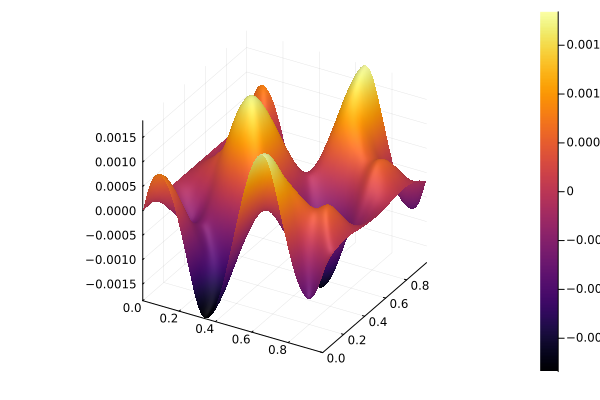

In [96]:
Ef1 = reshape(u,(3,J...))[1,:,:]

surface(yv,xv,Ef1)

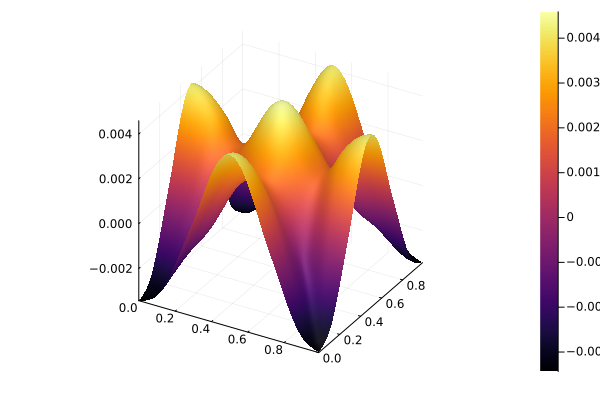

In [97]:
Bf = reshape(u,(3,J...))[3,:,:]

surface(yv,xv,Bf)